## Bare pretrained Resnet backbone evaluation

In [75]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np
from torch.nn import functional as F

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
efficient_net_dir = "../pretrained_backbone/ckpt_efficientnet_ep50.pt"

In [76]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import os
os.chdir("/content/drive/MyDrive/Projects/ODIR/task2_loss")

## Datasets

In [79]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [80]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [81]:
BATCH = 32

train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)

offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [82]:
class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)

    def forward(self, X):
        return self.model(X)

model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
summary(model, (3, 256, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

## No fine-tuning: Evaluation directly on ODIR test set

In [83]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()

    with torch.no_grad():
      for X, _ in tqdm(loader):
        output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
        preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

### Onsite

In [84]:
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

              precision    recall  f1-score   support

           D       0.72      0.28      0.40       140
           G       0.44      0.78      0.56        49
           A       0.30      0.64      0.41        22

   micro avg       0.48      0.43      0.46       211
   macro avg       0.49      0.56      0.46       211
weighted avg       0.61      0.43      0.44       211
 samples avg       0.48      0.42      0.36       211



### Offsite

![](efficientnet_no_tuning.png)

In [85]:
eval_model(model, onsite_test, "efficient_submission_notune.csv")

100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


## Frozen backbone, fine-tuning classifier only

In [86]:
params = model.parameters()
for layer in params:
        layer.requires_grad = False
for param in model.model.classifier[1].parameters():
        param.requires_grad = True
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [87]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            if device == "cuda":
                X = X.to(device)
                Y = Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)

        train_loss = train_loss / train_size

        model.eval()
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                if device == "cuda":
                    X = X.to(device)
                    Y = Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                val_accuracy += accuracy_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy())
                val_f1 += f1_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy(),average='samples')

        val_loss = val_loss / eval_size
        val_accuracy /= np.ceil(eval_size/BATCH)
        val_f1 /= np.ceil(eval_size/BATCH)

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (avg. samples): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss :
            print("Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()

    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (avg. samples)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

In [88]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean', task_type='binary', num_classes=None):
        """
        Unified Focal Loss class for binary, multi-class, and multi-label classification tasks.
        :param gamma: Focusing parameter, controls the strength of the modulating factor (1 - p_t)^gamma
        :param alpha: Balancing factor, can be a scalar or a tensor for class-wise weights. If None, no class balancing is used.
        :param reduction: Specifies the reduction method: 'none' | 'mean' | 'sum'
        :param task_type: Specifies the type of task: 'binary', 'multi-class', or 'multi-label'
        :param num_classes: Number of classes (only required for multi-class classification)
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.task_type = task_type
        self.num_classes = num_classes

        # Handle alpha for class balancing in multi-class tasks
        if task_type == 'multi-class' and alpha is not None and isinstance(alpha, (list, torch.Tensor)):
            assert num_classes is not None, "num_classes must be specified for multi-class classification"
            if isinstance(alpha, list):
                self.alpha = torch.Tensor(alpha)
            else:
                self.alpha = alpha

    def forward(self, inputs, targets):
        """
        Forward pass to compute the Focal Loss based on the specified task type.
        :param inputs: Predictions (logits) from the model.
                       Shape:
                         - binary/multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size, num_classes)
        :param targets: Ground truth labels.
                        Shape:
                         - binary: (batch_size,)
                         - multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size,)
        """
        if self.task_type == 'binary':
            return self.binary_focal_loss(inputs, targets)
        elif self.task_type == 'multi-class':
            return self.multi_class_focal_loss(inputs, targets)
        elif self.task_type == 'multi-label':
            return self.multi_label_focal_loss(inputs, targets)
        else:
            raise ValueError(
                f"Unsupported task_type '{self.task_type}'. Use 'binary', 'multi-class', or 'multi-label'.")

    def binary_focal_loss(self, inputs, targets):
        """ Focal loss for binary classification. """
        probs = torch.sigmoid(inputs)
        targets = targets.float()

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weighting
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_class_focal_loss(self, inputs, targets):
        """ Focal loss for multi-class classification. """
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)

        # Convert logits to probabilities with softmax
        probs = F.softmax(inputs, dim=1)

        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute cross-entropy for each class
        ce_loss = -targets_one_hot * torch.log(probs)

        # Compute focal weight
        p_t = torch.sum(probs * targets_one_hot, dim=1)  # p_t for each sample
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided (per-class weighting)
        if self.alpha is not None:
            alpha_t = alpha.gather(0, targets)
            ce_loss = alpha_t.unsqueeze(1) * ce_loss

        # Apply focal loss weight
        loss = focal_weight.unsqueeze(1) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_label_focal_loss(self, inputs, targets):
        """ Focal loss for multi-label classification. """
        probs = torch.sigmoid(inputs)

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weight
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.69it/s]


Epoch: 0 - Train Loss: 0.493645 - Val Loss: 0.196756 - Val Accuracy: 0.325893 - Val F1 (avg. samples): 0.569940
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch: 1 - Train Loss: 0.099188 - Val Loss: 0.089907 - Val Accuracy: 0.330357 - Val F1 (avg. samples): 0.677083
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


Epoch: 2 - Train Loss: 0.059068 - Val Loss: 0.054384 - Val Accuracy: 0.446429 - Val F1 (avg. samples): 0.721726
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch: 3 - Train Loss: 0.047176 - Val Loss: 0.051383 - Val Accuracy: 0.446429 - Val F1 (avg. samples): 0.718750
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch: 4 - Train Loss: 0.043763 - Val Loss: 0.052630 - Val Accuracy: 0.410714 - Val F1 (avg. samples): 0.707589


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch: 5 - Train Loss: 0.044103 - Val Loss: 0.048616 - Val Accuracy: 0.446429 - Val F1 (avg. samples): 0.725446
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s]


Epoch: 6 - Train Loss: 0.042855 - Val Loss: 0.050471 - Val Accuracy: 0.473214 - Val F1 (avg. samples): 0.745536


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch: 7 - Train Loss: 0.042506 - Val Loss: 0.051781 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.751488


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch: 8 - Train Loss: 0.040208 - Val Loss: 0.052633 - Val Accuracy: 0.513393 - Val F1 (avg. samples): 0.739583


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch: 9 - Train Loss: 0.038819 - Val Loss: 0.046477 - Val Accuracy: 0.513393 - Val F1 (avg. samples): 0.755952
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]


Epoch: 10 - Train Loss: 0.038852 - Val Loss: 0.048066 - Val Accuracy: 0.513393 - Val F1 (avg. samples): 0.751488


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.62it/s]


Epoch: 11 - Train Loss: 0.037398 - Val Loss: 0.049517 - Val Accuracy: 0.549107 - Val F1 (avg. samples): 0.754464


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch: 12 - Train Loss: 0.038505 - Val Loss: 0.047321 - Val Accuracy: 0.535714 - Val F1 (avg. samples): 0.755952


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]


Epoch: 13 - Train Loss: 0.036030 - Val Loss: 0.046968 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.753720


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch: 14 - Train Loss: 0.036387 - Val Loss: 0.049761 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.755208


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]


Epoch: 15 - Train Loss: 0.036505 - Val Loss: 0.046291 - Val Accuracy: 0.486607 - Val F1 (avg. samples): 0.758333
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


Epoch: 16 - Train Loss: 0.035288 - Val Loss: 0.052592 - Val Accuracy: 0.486607 - Val F1 (avg. samples): 0.723958


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]


Epoch: 17 - Train Loss: 0.035129 - Val Loss: 0.046972 - Val Accuracy: 0.549107 - Val F1 (avg. samples): 0.769345


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Epoch: 18 - Train Loss: 0.036259 - Val Loss: 0.046766 - Val Accuracy: 0.540179 - Val F1 (avg. samples): 0.768601


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.66it/s]


Epoch: 19 - Train Loss: 0.034599 - Val Loss: 0.047004 - Val Accuracy: 0.540179 - Val F1 (avg. samples): 0.767857


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch: 20 - Train Loss: 0.034194 - Val Loss: 0.046218 - Val Accuracy: 0.562500 - Val F1 (avg. samples): 0.767113
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch: 21 - Train Loss: 0.034158 - Val Loss: 0.047300 - Val Accuracy: 0.535714 - Val F1 (avg. samples): 0.755208


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch: 22 - Train Loss: 0.033256 - Val Loss: 0.048379 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.752232


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch: 23 - Train Loss: 0.033087 - Val Loss: 0.046145 - Val Accuracy: 0.571429 - Val F1 (avg. samples): 0.775298
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch: 24 - Train Loss: 0.034774 - Val Loss: 0.051475 - Val Accuracy: 0.553571 - Val F1 (avg. samples): 0.745536


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch: 25 - Train Loss: 0.034315 - Val Loss: 0.044085 - Val Accuracy: 0.544643 - Val F1 (avg. samples): 0.773958
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch: 26 - Train Loss: 0.032914 - Val Loss: 0.047292 - Val Accuracy: 0.540179 - Val F1 (avg. samples): 0.753720


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch: 27 - Train Loss: 0.033061 - Val Loss: 0.049440 - Val Accuracy: 0.540179 - Val F1 (avg. samples): 0.745536


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch: 28 - Train Loss: 0.033890 - Val Loss: 0.046424 - Val Accuracy: 0.558036 - Val F1 (avg. samples): 0.777530


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch: 29 - Train Loss: 0.033799 - Val Loss: 0.045724 - Val Accuracy: 0.558036 - Val F1 (avg. samples): 0.758929


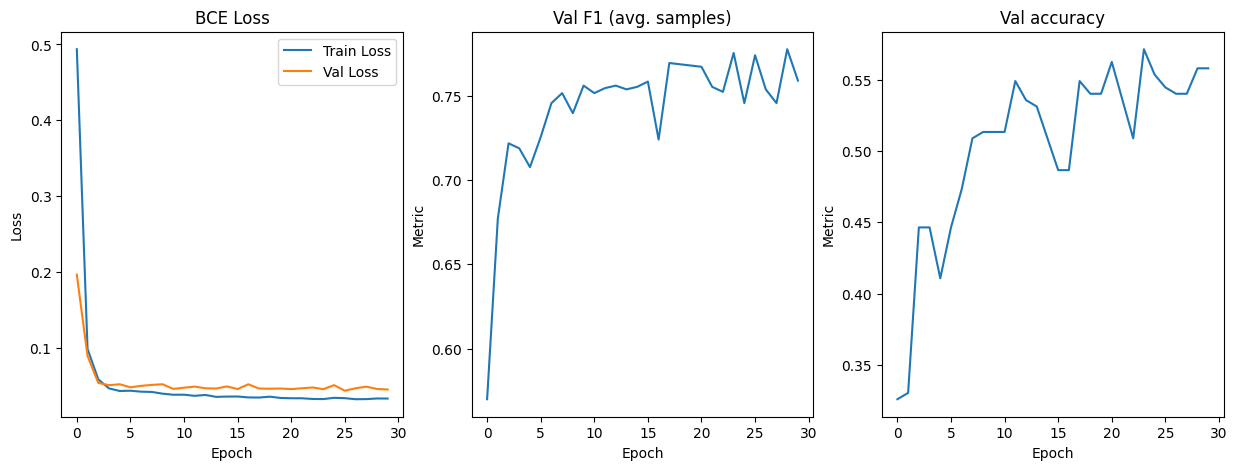

In [89]:
optimizer = torch.optim.AdamW(model.model.classifier[1].parameters(), lr = 1e-3)
criterion = FocalLoss(gamma=2, alpha=0.75, task_type='multi-label').to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.8)
result = train_model(model, train, val, optimizer, criterion, epochs=30, stepLR=scheduler, checkpoint_name="efficient_tuned_classifer.pt")

### Offsite test

In [90]:
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "efficient_tuned_classifer.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  5.88it/s]

              precision    recall  f1-score   support

           D       0.79      0.96      0.87       140
           G       0.58      0.76      0.65        49
           A       0.45      0.77      0.57        22

   micro avg       0.69      0.89      0.78       211
   macro avg       0.61      0.83      0.70       211
weighted avg       0.71      0.89      0.79       211
 samples avg       0.76      0.90      0.80       211



### Onsite test
![](efficientnet_classifier_tuning.png)

In [91]:
eval_model(model, onsite_test, "efficient_net_submission_classifier_tune_focal_loss.csv")

100%|██████████| 8/8 [00:01<00:00,  4.81it/s]


## Full fine-tuning

Only 3 epochs no more, usually overfits after epoch 1, lr = 1e-4 seem to be most optimal, no weight decay

Validation: 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch: 0 - Train Loss: 0.064456 - Val Loss: 0.090909 - Val Accuracy: 0.584821 - Val F1 (avg. samples): 0.777530
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


Epoch: 1 - Train Loss: 0.063686 - Val Loss: 0.090708 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.782738
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.40it/s]


Epoch: 2 - Train Loss: 0.063633 - Val Loss: 0.090222 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.780506
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.48it/s]


Epoch: 3 - Train Loss: 0.063351 - Val Loss: 0.090514 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.773065


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch: 4 - Train Loss: 0.064881 - Val Loss: 0.089772 - Val Accuracy: 0.598214 - Val F1 (avg. samples): 0.775298
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


Epoch: 5 - Train Loss: 0.062272 - Val Loss: 0.090472 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.781250


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.49it/s]


Epoch: 6 - Train Loss: 0.062891 - Val Loss: 0.090508 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.783482


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


Epoch: 7 - Train Loss: 0.061891 - Val Loss: 0.091041 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.778274


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


Epoch: 8 - Train Loss: 0.066413 - Val Loss: 0.091432 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.781994


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch: 9 - Train Loss: 0.060172 - Val Loss: 0.090320 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.786458


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch: 10 - Train Loss: 0.060078 - Val Loss: 0.091424 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.775298


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


Epoch: 11 - Train Loss: 0.062388 - Val Loss: 0.091313 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.782738


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


Epoch: 12 - Train Loss: 0.059287 - Val Loss: 0.090510 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.783482


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]


Epoch: 13 - Train Loss: 0.061149 - Val Loss: 0.090806 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.783482


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch: 14 - Train Loss: 0.059602 - Val Loss: 0.090166 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.788690


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch: 15 - Train Loss: 0.060469 - Val Loss: 0.090654 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.784970


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.37it/s]


Epoch: 16 - Train Loss: 0.056207 - Val Loss: 0.090667 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.783482


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


Epoch: 17 - Train Loss: 0.059233 - Val Loss: 0.090443 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.779018


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch: 18 - Train Loss: 0.057495 - Val Loss: 0.090730 - Val Accuracy: 0.611607 - Val F1 (avg. samples): 0.780506


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch: 19 - Train Loss: 0.056830 - Val Loss: 0.090916 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.778274


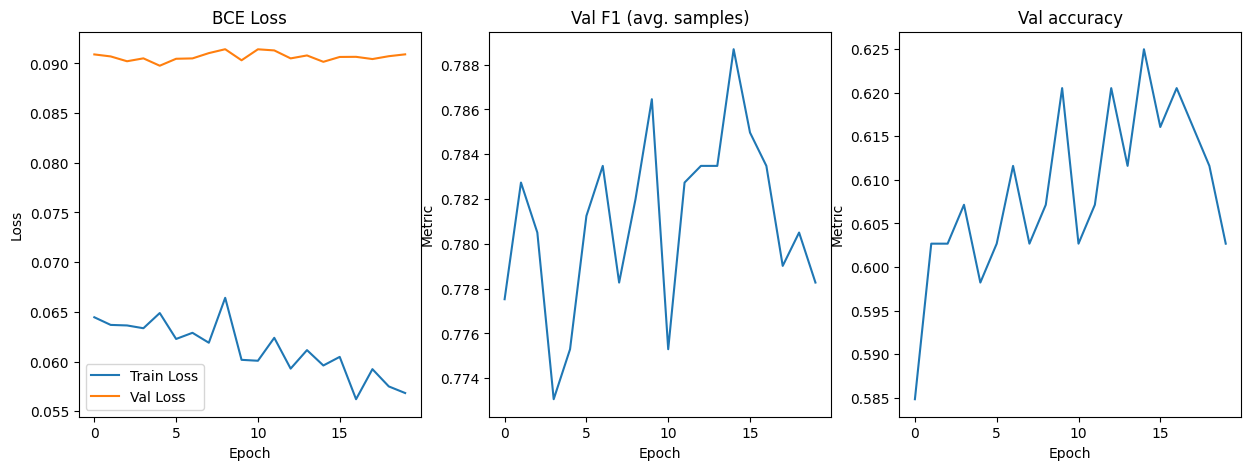

In [98]:
for layer in model.parameters():
    layer.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-6)
criterion = FocalLoss(gamma=1, alpha=0.65, task_type='multi-label').to(device)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)
result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=20, stepLR=scheduler, checkpoint_name="efficient.pt")

### Offsite

In [96]:
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "efficient.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  6.06it/s]

              precision    recall  f1-score   support

           D       0.81      0.94      0.87       140
           G       0.73      0.73      0.73        49
           A       0.50      0.68      0.58        22

   micro avg       0.76      0.87      0.81       211
   macro avg       0.68      0.79      0.73       211
weighted avg       0.76      0.87      0.81       211
 samples avg       0.81      0.88      0.82       211



### Onsite test
![](efficientnet_classifier_full.png)

In [97]:
eval_model(model, onsite_test, "efficient_net_submission_full_focal_loss.csv")

100%|██████████| 8/8 [00:01<00:00,  5.03it/s]
